# Latency of image arrival at USDF after shutter close on LSSTCam

In [ ]:
# This cell is only for setting parameter defaults
day = "20241002"

In [ ]:
from lsst.daf.butler import Butler
from lsst.daf.butler.registry import Registry
import sqlalchemy
from astropy import time


repo = 'embargo_new'
instrument = 'LSSTCam'
dt = 'raw'
# raw all collection contains all images 
collections = [f'{instrument}/raw/all']
butler = Butler(repo, collections=collections, instrument=instrument)
where = f"day_obs={day}"

# Data transferred and ingested in butler and access to data



In [ ]:
with butler.query() as q:
    q = q.join_dataset_search(dt,collections)
    q = q.where(day_obs=int(day))
    rows = q.general(["exposure"], "raw.ingest_date", find_first=False)
    # ordering by exposure.id ('.id' is optional) and ingest_date (or 'raw.ingest_date')
    result = list(rows.order_by("exposure", "ingest_date"))

print (f"Got ingest times for {len(result)} images on day_obs={day}")


### latency ..
"Measure the delays between completion of readout for each image and the ingestion time recorded in the Butler Registry."
Get the shuter close time for each exposre 
the ID in the dimension record is the exposure ID (dimensionRecord.id)
thed timespan.end is the sutter close time 


In [ ]:
import numpy as np
from astropy.time import Time

shutterTimes = butler.registry.queryDimensionRecords('exposure', where=where, instrument=instrument)
nt = shutterTimes.count()

print (f"Got Metadata (DimensionRecords) for {nt} exposures")


Use the exposure times to work out the time for each imagetransfer  and the max and min for each exposure

In [ ]:
exptimes = {}
for exp in shutterTimes:
    exptimes[exp.id] = exp.timespan.end

ingest_times = [res["raw.ingest_date"] for res in result]
exposure_times = [exptimes[res["exposure"]] for res in result]

seconds = (Time(ingest_times) - Time(exposure_times)).to('second')  # per image


In [ ]:
min = 100.0
max = 0.0
prev = None
prevt = 0
startexp = 0
nt = len(exptimes)
ecount = 0
expt = np.array([t.to_value('mjd') for t in exptimes.values()])  # per exposure 
expmins  = np.empty(shape = [nt]) # the fastest tranfer
expmaxs  = np.empty(shape = [nt]) # slowes transfer
for count, ts in enumerate(seconds):
    t = ts.value
    if exposure_times[count] != prev : # boundary of exposure - individial times should be ordered
        expmins[ecount] = t
        if ecount > 0:
            expmaxs[ecount] = prevt
        ecount = ecount + 1
        prev = exposure_times[count]
        if t < min:
           min = t
        if prevt > max:
           max = prevt 
    prevt = t


In [ ]:
print (f"Counted {ecount +1} exposures.")
print (f"The min time was {min} max time was {max} seconds over {len(seconds)} times.")
print (f"Time between shutter close and ingest mean:{np.mean(seconds)}, std:{np.std(seconds)}, var:{np.var(seconds)}")

In [ ]:
import matplotlib.pyplot as plt
plt.hist(seconds,bins='auto')
plt.title(f"Shutter close to ingest times(s) for {len(seconds)} images on {day}")
plt.axvline(x = 7, color = 'r', linestyle = '-', ymin=0, ymax=1) 

plt.show()

Red line is 7 seconds

## The max and min transfer time for each exposure
For each exposure the fastes (blue) and slowest (orange) file transfer is ploted. 

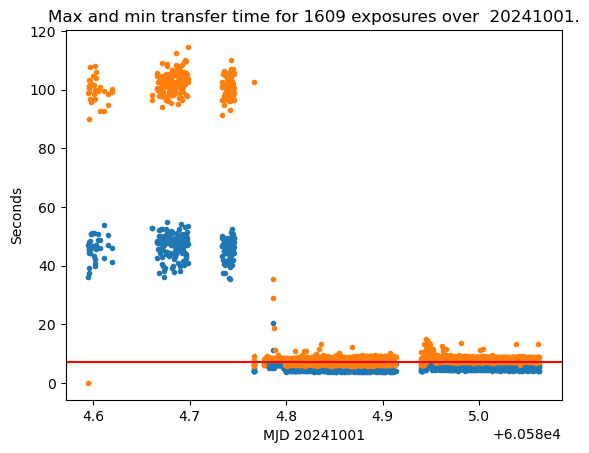

In [51]:

plt.scatter(expt, expmins, marker=".")
plt.scatter(expt, expmaxs, marker=".")
plt.xlabel(f"MJD {day}")
plt.ylabel("Seconds")
plt.title(f"Max and min transfer time for {len(expt)} exposures over  {day}.")
plt.axhline(y = 7, color = 'r', linestyle = '-') 
plt.show()

## Time between exposures 

In [ ]:
expt.sort()
expts = expt[1:]

betweentimes = (Time(expts, format='mjd') - Time(expt[0:-1], format='mjd')).to('second')  # per image

#print(f"Got {len(betweentimes)} betweentimes and {len(expts)} exposures.")
#print (f"Time between exposures mean:{np.mean(betweentimes)}, std:{np.std(betweentimes)}, var:{np.var(betweentimes)} seconds")


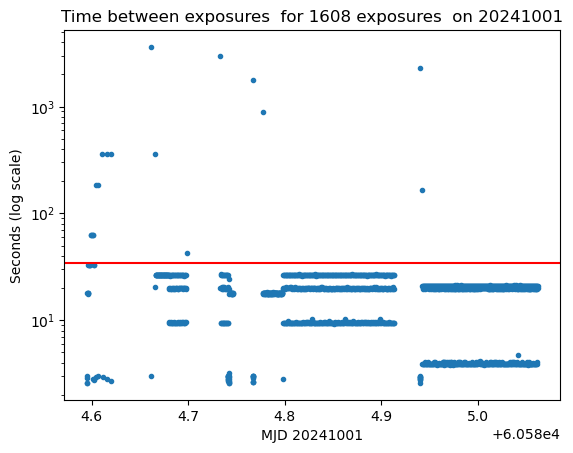

In [52]:
plt.scatter(expts, betweentimes, marker=".")
plt.axhline(y = 34, color = 'r', linestyle = '-') 
plt.yscale('log')
plt.xlabel(f"MJD {day}")
plt.ylabel("Seconds (log scale)")
plt.title(f"Time between exposures  for {len(betweentimes)} exposures  on {day}")
plt.show()

Red line is 34 sec nominal time between exposures